In [110]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt


# Goal is to create a NN to take trigrams or more
1. Create X with input letters, create Y with output. Need to create itos and stoi
3. Create C which is a lookup table of dimension 2
4. Create a NN that takes that and gives our probabilities of next letter
5. calculate loss and reduce loss

In [3]:
words = open('names.txt', 'r').read().splitlines()
print(words[:5])

['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [4]:
# create itos and stoi
chars = sorted(set(''.join(words)))
itos = {i+1: ch for i, ch in enumerate(chars)}
itos[0] = '.'
stoi = {ch: i for i, ch in itos.items()}



In [30]:
import numpy as np
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [34]:
emb_size = 10
hidden_size = 300


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, emb_size), generator=g)
W1 = torch.randn((block_size * emb_size, hidden_size),  generator=g) * ((5/3)/((block_size * emb_size)**0.5))
#B1 = torch.randn((hidden_size), generator=g) * 0.01
W2 = torch.randn((hidden_size, 27), generator=g) * 0.01
B2 = torch.randn((27), generator=g) * 0

bngain = torch.ones(((1, hidden_size)))
bnbias = torch.zeros((1, hidden_size))

bnmean_running = torch.zeros((1, hidden_size))
bnstd_running = torch.ones((1, hidden_size))

parameters = [C, W1, W2, B2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

17997


In [35]:
batch_size = 32
n_epochs = 200000

for i in range(n_epochs):
    # forward pass
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    emb = C[Xtr[ix]]
    embcat = emb.view(-1, block_size * emb_size)
    #-------------batch norm----------------
    hprev = embcat @ W1 #+ B1
    bnmeani = hprev.mean(0, keepdim=True)
    bnstdi = hprev.std(0, keepdim=True)
    hprev = (hprev - bnmeani)/bnstdi
    hprev = hprev * bngain + bnbias

    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
        bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001

    h = torch.tanh(hprev)
    #-------------------------------
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Ytr[ix])


    for p in parameters:
        p.grad = None

    loss.backward()
    lr = 0.1 if i < (n_epochs * 0.8) else 0.01
    for p in parameters:
        p.data -= lr * p.grad 
print(loss.item())

2.061699390411377


In [37]:
#beat xDev of 2.17 loss
emb = C[Xdev]
embcat = emb.view(-1, block_size * emb_size)
hprev = embcat @ W1 #+ B1
hprev = (hprev - bnmean_running) / bnstd_running
hprev = hprev * bngain + bnbias
h = torch.tanh(hprev)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.097026824951172


In [38]:
emb = C[Xte]
embcat = emb.view(-1, block_size * emb_size)
hprev = embcat @ W1 #+ B1
hprev = (hprev - bnmean_running) / bnstd_running
hprev = hprev * bngain + bnbias
h = torch.tanh(hprev)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.100803852081299


## Below is the code to torichify the whole Linear layer along with batch norm

In [40]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(set(''.join(words)))
itos = {i+1: ch for i, ch in enumerate(chars)}
itos[0] = '.'
stoi = {ch: i for i, ch in itos.items()}
vocab_size = len(itos)

In [133]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        p = [self.weight] + ([] if self.bias is None else [self.bias])
        return p
    

class BatchNorm1d:
    def __init__(self, dim, esp=1e-5, momentum=0.1):
        self.esp = esp
        self.momentum = momentum
        self.training = True
        # running mean to keep track of things
        self.mean_running = torch.zeros(1,dim)
        self.std_running = torch.ones(1, dim)
        # paramaters for normalization
        self.gamma = torch.ones(1, dim)
        self.beta = torch.zeros(1, dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.mean_running
            xvar = self.std_running
            
        xhat = (x - xmean) / (xvar + self.esp)
        if self.training:
            with torch.no_grad():
                self.mean_running = self.mean_running * (1-self.momentum) + xmean * self.momentum
                self.std_running = self.std_running * (1-self.momentum) + xvar * self.momentum

        self.out = self.gamma * xhat + self.beta
        return self.out
        
    def parameters(self):
        return [self.gamma, self.beta]
        
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [148]:
n_embd = 10
n_hidden = 300
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  layers[-1].gamma *= 0.1
  
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

380451


In [149]:
# run optimisationz

max_steps = 200000
batch_size = 32

# store stats
losses = []
ud = []


for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for l in layers:
        x = l(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    
    for p in parameters:
        p.grad = None
    
    loss.backward()
    losses.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 1000 == 0:
        print(f"{i}: {loss.item()}")
        break

0: 3.303079843521118
1000: 2.435180425643921
2000: 2.7765250205993652


KeyboardInterrupt: 

layer 2 (Tanh): mean +0.00, std 0.20, saturated: 0.00%
layer 5 (Tanh): mean -0.00, std 0.29, saturated: 0.00%
layer 8 (Tanh): mean +0.00, std 0.20, saturated: 0.00%
layer 11 (Tanh): mean -0.00, std 0.28, saturated: 0.00%
layer 14 (Tanh): mean +0.00, std 0.20, saturated: 0.00%


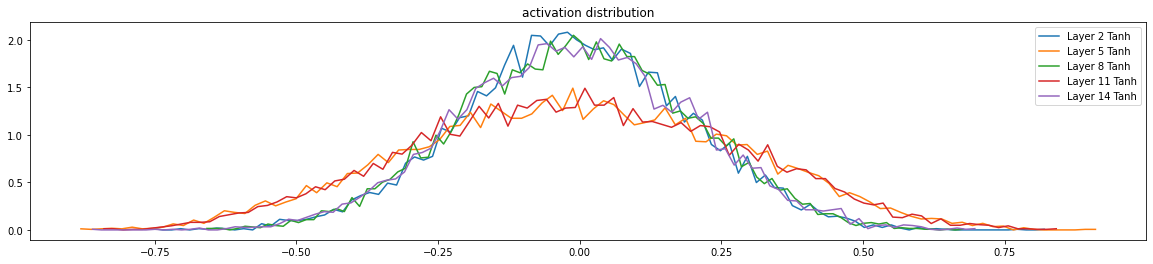

In [136]:
# plot activation distribution
plt.figure(figsize=(20, 4))
legend = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
       #print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legend.append(f'Layer {i} {layer.__class__.__name__}')
plt.legend(legend)
plt.title("activation distribution")
plt.show()



layer 2 (Tanh): mean +0.000000, std 4.352693e-03
layer 5 (Tanh): mean +0.000000, std 2.732911e-03
layer 8 (Tanh): mean +0.000000, std 3.496308e-03
layer 11 (Tanh): mean -0.000000, std 2.286542e-03
layer 14 (Tanh): mean +0.000000, std 3.099193e-03


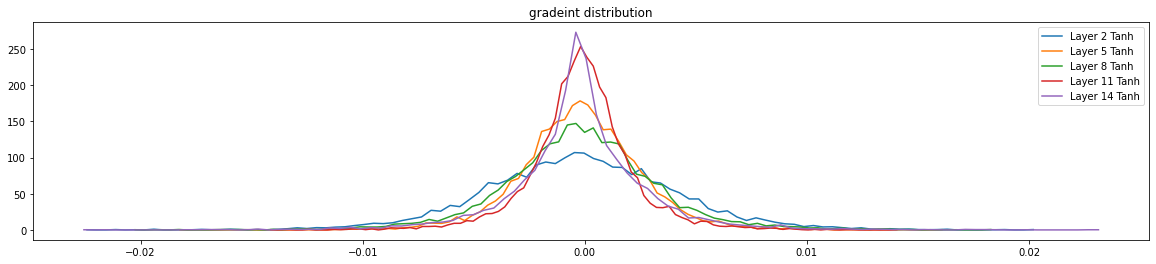

In [137]:
# plot gradient distribution
plt.figure(figsize=(20, 4))
legend = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legend.append(f'Layer {i} {layer.__class__.__name__}')
plt.legend(legend)
plt.title("gradeint distribution")
plt.show()

weight   (27, 10) | mean +0.000000 | std 4.634987e-03 | grad:data ratio 4.616757e-03
weight  (30, 300) | mean -0.000001 | std 1.138361e-03 | grad:data ratio 1.119503e-03
weight   (1, 300) | mean +0.000178 | std 5.281373e-03 | grad:data ratio 2.295408e-01
weight   (1, 300) | mean +0.000126 | std 1.252162e-03 | grad:data ratio 1.866912e-01
weight (300, 300) | mean -0.000001 | std 3.325804e-04 | grad:data ratio 3.320931e-04
weight   (1, 300) | mean -0.000204 | std 4.374119e-03 | grad:data ratio 2.573364e-01
weight   (1, 300) | mean +0.000183 | std 1.563719e-03 | grad:data ratio 2.394891e-01
weight (300, 300) | mean -0.000001 | std 3.039106e-04 | grad:data ratio 3.032612e-04
weight   (1, 300) | mean +0.000220 | std 4.602967e-03 | grad:data ratio 2.412447e-01
weight   (1, 300) | mean -0.000082 | std 1.107172e-03 | grad:data ratio 2.129927e-01
weight (300, 300) | mean -0.000000 | std 2.734711e-04 | grad:data ratio 2.734443e-04
weight   (1, 300) | mean -0.000263 | std 3.726400e-03 | grad:data

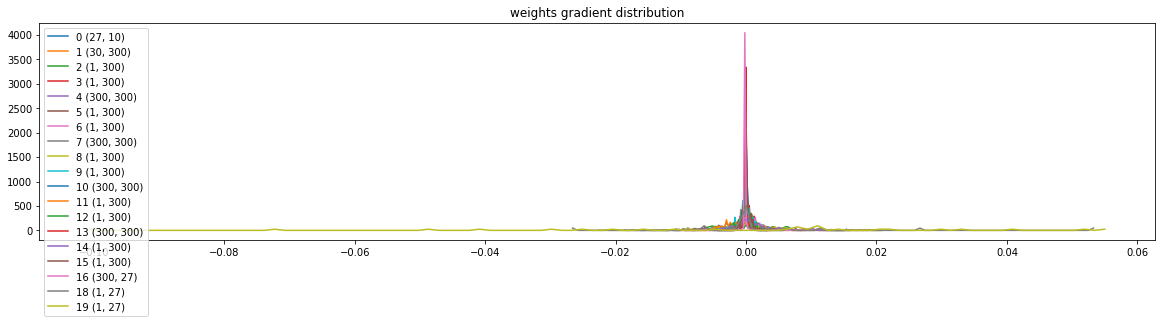

In [138]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

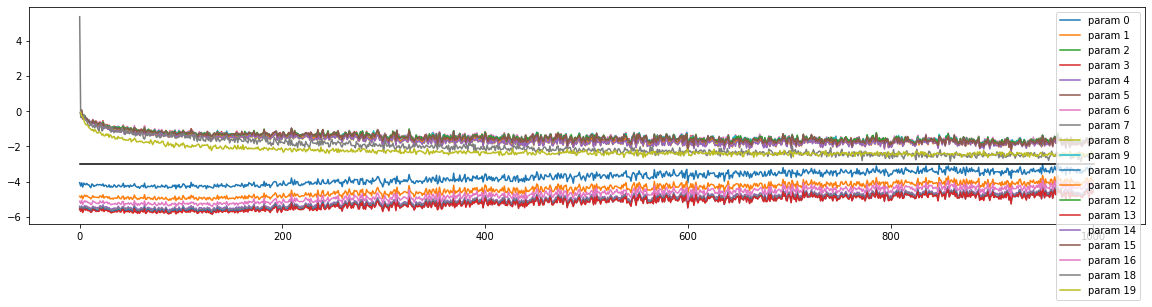

In [139]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [140]:
# inference

g = torch.Generator().manual_seed(2147483647 + 10)

for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))




/var/folders/x5/dnzh449x6b3__4kx4_l_ypj00000gn/T/ipykernel_69381/3107495822.py:32: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  xvar = x.var(0, keepdim=True)


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0